In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

sns.set_theme(style="whitegrid")

In [2]:
TRAIN_DIR = Path("../data/Training")
TEST_DIR = Path("../data/Testing")

def get_split_counts(split_dir: Path) -> dict:
    class_names = sorted([p.name for p in split_dir.iterdir() if p.is_dir()])
    return {cls: len(list((split_dir / cls).glob("*"))) for cls in class_names}

train_counts = get_split_counts(TRAIN_DIR)
test_counts = get_split_counts(TEST_DIR)

class_order = sorted(set(train_counts) | set(test_counts))

df_counts = pd.DataFrame(
    {
        "class": class_order,
        "train": [train_counts.get(cls, 0) for cls in class_order],
        "test": [test_counts.get(cls, 0) for cls in class_order],
    }
)
df_counts["total"] = df_counts["train"] + df_counts["test"]
df_counts["train_pct"] = (df_counts["train"] / df_counts["total"] * 100).round(1)

display(df_counts.sort_values("class").reset_index(drop=True))

,class,train,test,total,train_pct
0,glioma,1321,300,1621,81.5
1,meningioma,1339,306,1645,81.4
2,notumor,1595,405,2000,79.8
3,pituitary,1457,300,1757,82.9


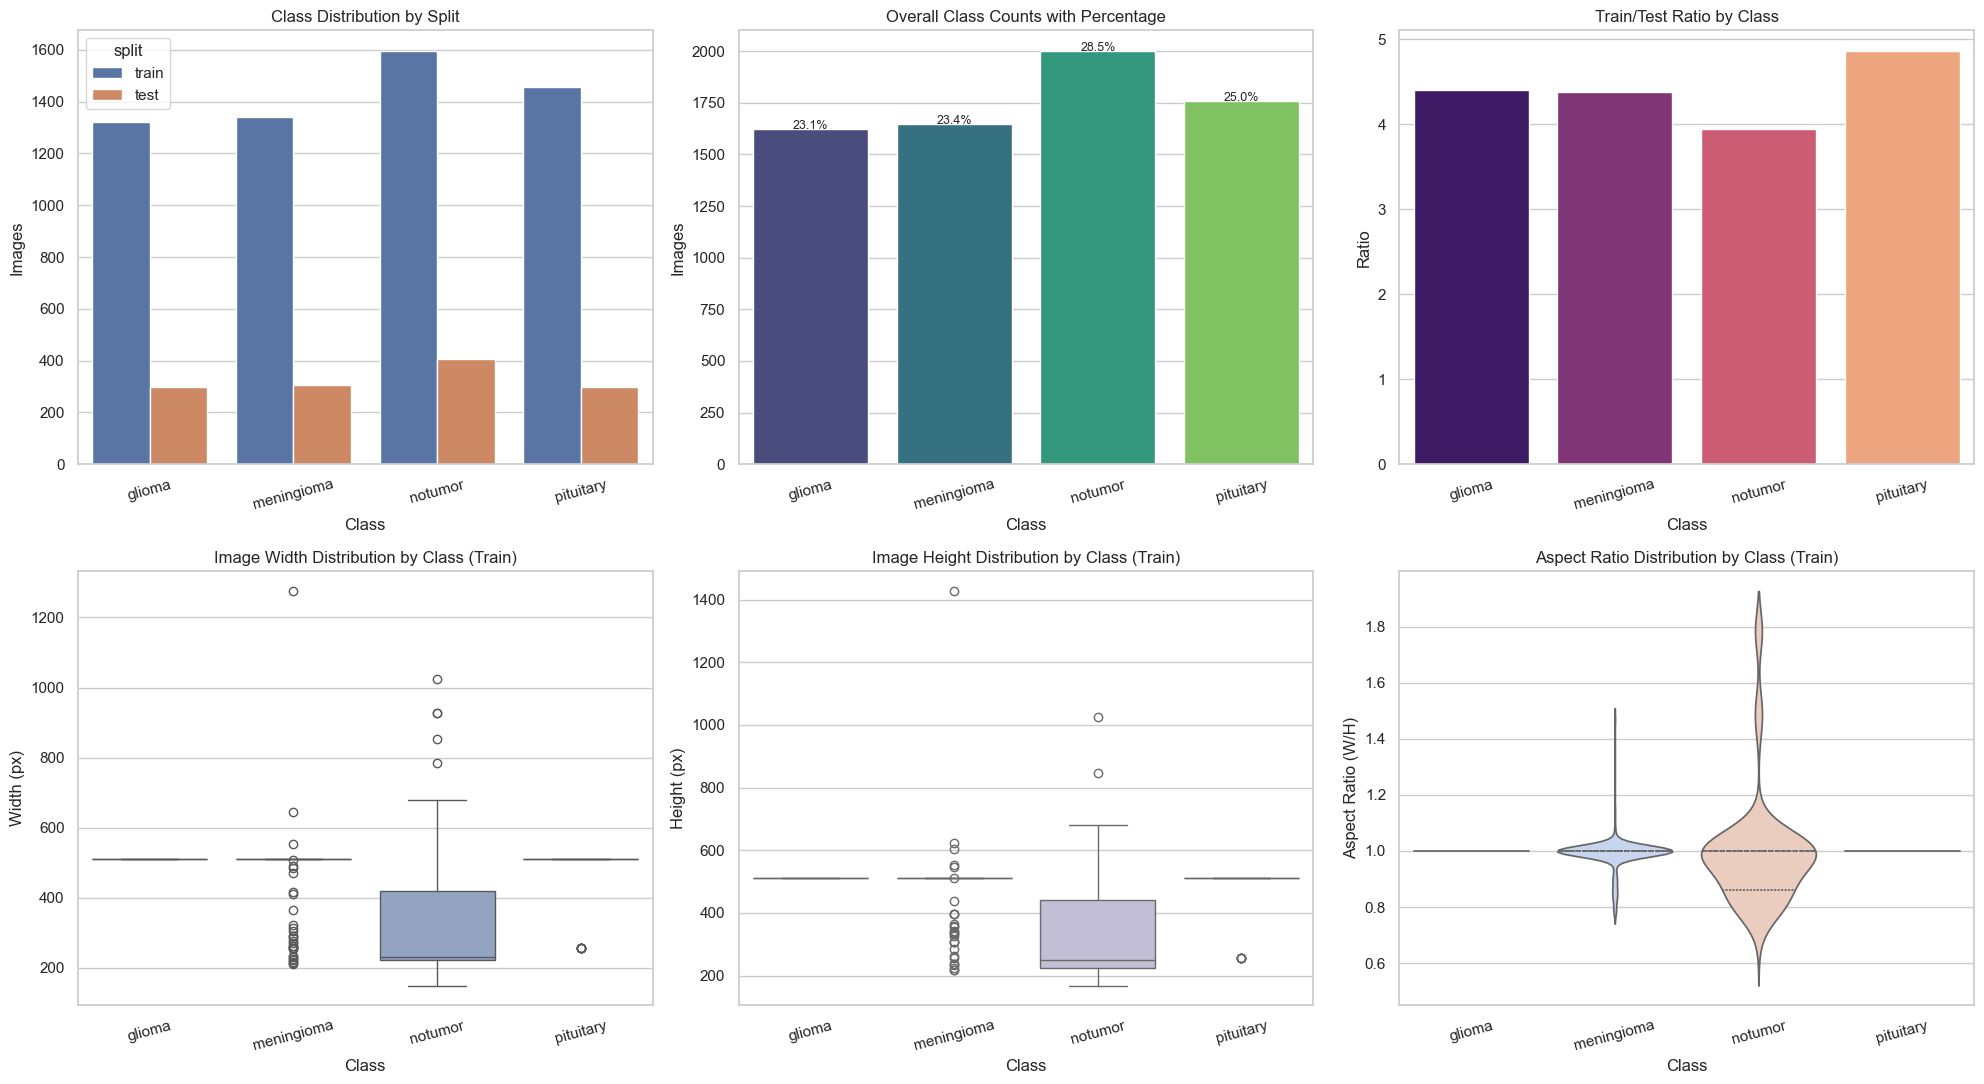

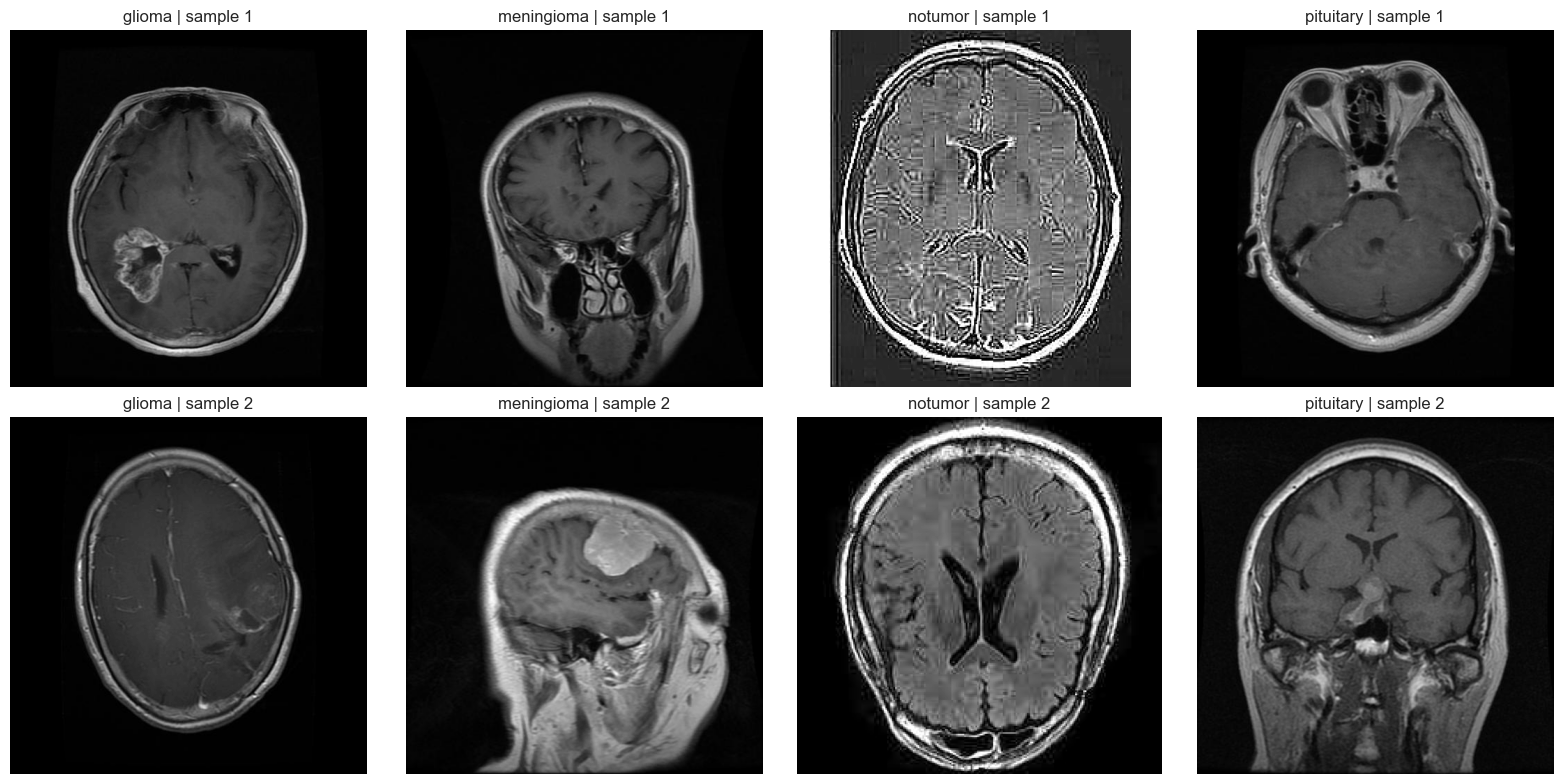

width                            height                      \
              mean     std median  min   max    mean     std median  min   
class                                                                      
glioma      512.00    0.00  512.0  512   512  512.00    0.00  512.0  512   
meningioma  489.36   95.90  512.0  212  1275  493.84   96.76  512.0  216   
notumor     326.54  171.02  232.0  150  1024  329.88  158.49  249.0  168   
pituitary   504.32   43.78  512.0  256   512  504.32   43.78  512.0  256   

                 aspect                           
             max   mean   std median   min   max  
class                                             
glioma       512   1.00  0.00    1.0  1.00  1.00  
meningioma  1427   0.99  0.06    1.0  0.78  1.47  
notumor     1024   0.99  0.20    1.0  0.66  1.79  
pituitary    512   1.00  0.00    1.0  1.00  1.00

In [4]:
# --- Detailed visualization dashboard ---
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

# 1) Train vs Test class distribution
df_melt = df_counts.melt(id_vars="class", value_vars=["train", "test"], var_name="split", value_name="count")
sns.barplot(data=df_melt, x="class", y="count", hue="split", ax=axes[0, 0])
axes[0, 0].set_title("Class Distribution by Split")
axes[0, 0].set_xlabel("Class")
axes[0, 0].set_ylabel("Images")
axes[0, 0].tick_params(axis="x", rotation=15)

# 2) Class share (%) across complete dataset
sns.barplot(data=df_counts, x="class", y="total", hue="class", palette="viridis", legend=False, ax=axes[0, 1])
total_images = df_counts["total"].sum()
for idx, (_, row) in enumerate(df_counts.iterrows()):
    pct = (row["total"] / total_images) * 100 if total_images else 0
    axes[0, 1].text(idx, row["total"] + 2, f"{pct:.1f}%", ha="center", fontsize=9)
axes[0, 1].set_title("Overall Class Counts with Percentage")
axes[0, 1].set_xlabel("Class")
axes[0, 1].set_ylabel("Images")
axes[0, 1].tick_params(axis="x", rotation=15)

# 3) Train/Test ratio by class
df_counts["tt_ratio"] = (df_counts["train"] / df_counts["test"]).round(2)
sns.barplot(data=df_counts, x="class", y="tt_ratio", hue="class", palette="magma", legend=False, ax=axes[0, 2])
axes[0, 2].set_title("Train/Test Ratio by Class")
axes[0, 2].set_xlabel("Class")
axes[0, 2].set_ylabel("Ratio")
axes[0, 2].tick_params(axis="x", rotation=15)

# Build image-size metadata (training set, sampled)
size_records = []
for cls in class_order:
    class_path = TRAIN_DIR / cls
    image_paths = list(class_path.glob("*"))[:200]  # sample for fast EDA
    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                width, height = img.size
            size_records.append({"class": cls, "width": width, "height": height, "aspect": width / height})
        except Exception:
            continue

sizes_df = pd.DataFrame(size_records)

if not sizes_df.empty:
    # 4) Width distribution
    sns.boxplot(data=sizes_df, x="class", y="width", hue="class", legend=False, palette="Set2", ax=axes[1, 0])
    axes[1, 0].set_title("Image Width Distribution by Class (Train)")
    axes[1, 0].set_xlabel("Class")
    axes[1, 0].set_ylabel("Width (px)")
    axes[1, 0].tick_params(axis="x", rotation=15)

    # 5) Height distribution
    sns.boxplot(data=sizes_df, x="class", y="height", hue="class", legend=False, palette="Set3", ax=axes[1, 1])
    axes[1, 1].set_title("Image Height Distribution by Class (Train)")
    axes[1, 1].set_xlabel("Class")
    axes[1, 1].set_ylabel("Height (px)")
    axes[1, 1].tick_params(axis="x", rotation=15)

    # 6) Aspect ratio distribution
    sns.violinplot(data=sizes_df, x="class", y="aspect", hue="class", legend=False, inner="quartile", palette="coolwarm", ax=axes[1, 2])
    axes[1, 2].set_title("Aspect Ratio Distribution by Class (Train)")
    axes[1, 2].set_xlabel("Class")
    axes[1, 2].set_ylabel("Aspect Ratio (W/H)")
    axes[1, 2].tick_params(axis="x", rotation=15)
else:
    for ax in axes[1, :]:
        ax.text(0.5, 0.5, "No image size metadata found", ha="center", va="center")
        ax.axis("off")

plt.tight_layout()
plt.show()

# Class-wise sample image grid (2 samples per class)
fig, axes = plt.subplots(2, len(class_order), figsize=(4 * len(class_order), 8))
for col, cls in enumerate(class_order):
    sample_paths = list((TRAIN_DIR / cls).glob("*"))[:2]
    for row in range(2):
        ax = axes[row, col] if len(class_order) > 1 else axes[row]
        if row < len(sample_paths):
            try:
                with Image.open(sample_paths[row]) as img:
                    ax.imshow(img.convert("L"), cmap="gray")
                ax.set_title(f"{cls} | sample {row+1}")
            except Exception:
                ax.text(0.5, 0.5, "Unreadable image", ha="center", va="center")
        else:
            ax.text(0.5, 0.5, "No sample", ha="center", va="center")
        ax.axis("off")
plt.tight_layout()
plt.show()

# Statistical summary table
if not sizes_df.empty:
    display(
        sizes_df.groupby("class")[["width", "height", "aspect"]]
        .agg(["mean", "std", "median", "min", "max"])
.round(2)
    )